In [1]:
#Import packages
import sys
sys.path.append("/Users/hudasaeed/anaconda3/lib/python3.11/site-packages")
import pandas as pd
import numpy as np
import googlemaps
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from bertopic import BERTopic
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize          
from nltk import pos_tag
from nltk.corpus import wordnet
import pickle
import plotly.io as pio
import random
import os
os.getcwd()

#Can skip data cleaning and go to cell with comment "Read reviews"

/Users/hudasaeed/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


'/Users/hudasaeed/Desktop/HDSF'

In [92]:
#US hospitals

us = pd.read_csv('US_hosp.csv')
us = us[us['State'].isin(['NY', 'PA', 'TX', 'AZ', 'CA', 'WA', 'FL', 'GA', 'IL', 'OH','RI',"MA"])] #filter for top states in each region
print(us['State'].value_counts()) #ensure filter worked
print(us.head())
us.shape


State
TX    452
CA    380
FL    215
OH    196
IL    195
NY    193
PA    190
GA    148
AZ    106
WA    102
MA     82
RI     13
Name: count, dtype: int64
    Facility ID                               Facility Name  \
125      030002  BANNER - UNIVERSITY MEDICAL CENTER PHOENIX   
126      030006                       TUCSON MEDICAL CENTER   
127      030007                 VERDE VALLEY MEDICAL CENTER   
128      030010                         ST. MARY'S HOSPITAL   
129      030011                        ST JOSEPH'S HOSPITAL   

                      Address   City/Town State  ZIP Code County/Parish  \
125   1111 EAST MCDOWELL ROAD     PHOENIX    AZ     85006      MARICOPA   
126      5301 EAST GRANT ROAD      TUCSON    AZ     85712          PIMA   
127      269 SOUTH CANDY LANE  COTTONWOOD    AZ     86326       YAVAPAI   
128  1601 WEST ST MARY'S ROAD      TUCSON    AZ     85745          PIMA   
129     350 NORTH WILMOT ROAD      TUCSON    AZ     85711          PIMA   

    Telephone Numb

(2272, 39)

In [93]:
#Ensure each row is a unique hospital
us = us.reset_index(drop=True)
print(len(set(us['Address']))) #less than the # of rows so some duplicates

dup = np.where(us['Address'].duplicated(keep=False)) #get duplicate address indices 
print(len([us['Address'][i] for i in dup[0]]))
print(len(set([us['Address'][i] for i in dup[0]]))) 
[f"{us['Address'][i]} {us['City/Town'][i]}" for i in dup[0]]

2265
14
7


['800 WASHINGTON STREET BOSTON',
 '800 WASHINGTON STREET NORWOOD',
 '2213 CHERRY STREET TOLEDO',
 '11100 EUCLID AVENUE CLEVELAND',
 '11100 EUCLID AVENUE CLEVELAND',
 '2213 CHERRY STREET TOLEDO',
 '100 HOSPITAL DRIVE ATHENS',
 'ONE HOSPITAL DRIVE LEWISBURG',
 'ONE HOSPITAL DRIVE CLARION',
 '200 HOSPITAL DRIVE MEYERSDALE',
 '100 HOSPITAL DRIVE MONTROSE',
 '100 MEDICAL DRIVE LAKE JACKSON',
 '200 HOSPITAL DRIVE ANAHUAC',
 '100 MEDICAL DRIVE BORGER']

In [21]:
us.iloc[dup[0][2:6],:] #all different


,Facility ID,Facility Name,Address,City/Town,State,ZIP Code,County/Parish,Telephone Number,Hospital Type,Hospital Ownership,...,Count of READM Measures Better,Count of READM Measures No Different,Count of READM Measures Worse,READM Group Footnote,Pt Exp Group Measure Count,Count of Facility Pt Exp Measures,Pt Exp Group Footnote,TE Group Measure Count,Count of Facility TE Measures,TE Group Footnote
1384,360112,MERCY ST VINCENT MEDICAL CENTER,2213 CHERRY STREET,TOLEDO,OH,43608,LUCAS,(419) 251-3232,Acute Care Hospitals,Voluntary non-profit - Church,...,0,9,2,NaN,8,8,NaN,12,8,NaN
1393,360137,UH CLEVELAND MEDICAL CENTER,11100 EUCLID AVENUE,CLEVELAND,OH,44106,CUYAHOGA,(440) 844-1000,Acute Care Hospitals,Voluntary non-profit - Private,...,0,7,4,NaN,8,8,NaN,12,10,NaN
1477,363302,RAINBOW BABIES AND CHILDRENS HOSPITAL,11100 EUCLID AVENUE,CLEVELAND,OH,44106,CUYAHOGA,(216) 844-1000,Childrens,Voluntary non-profit - Other,...,Not Available,Not Available,Not Available,19.0,Not Available,Not Available,19.0,Not Available,Not Available,19.0
1483,363309,"NATIONWIDE CHILDREN'S HOSPITAL TOLEDO, LLC",2213 CHERRY STREET,TOLEDO,OH,43608,LUCAS,(419) 251-3232,Childrens,Voluntary non-profit - Private,...,Not Available,Not Available,Not Available,19.0,Not Available,Not Available,19.0,Not Available,Not Available,19.0


In [4]:
#Get URLS fxn

gmaps = googlemaps.Client(key='')

def get_google_maps_url(place):
    #get place_id of the hospitals through their name
    places_result = gmaps.find_place(input=place, input_type='textquery', fields=['place_id'])

    #if successful and has results 
    if places_result['status'] == 'OK' and places_result['candidates']:
        place_id = places_result['candidates'][0]['place_id'] 
        # place_details = gmaps.place(place_id=place_id)
        
        # if place_details['status'] == 'OK':
        #         address_components = place_details['result'].get('address_components', [])
        #         for component in address_components:
        #             if 'administrative_area_level_1' in component['types'] and component['short_name'] == 'GB':
        return f"https://www.google.com/maps/place/?q=place_id:{place_id}"  # Format of URL with place_id

        # print(f"No Massachusetts location found for: {place}")
        # return None
    else:
        print(f"No hospital found for: {place}")
        return None

In [63]:
# Collect Google Maps URLs for hospitals
query = [f"{us['Facility Name'][i]} {us['City/Town'][i]} {us['State'][i]}" for i in range(2272)] #name+address for all rows
urls = []
batch_size = 100  # batches since API was overwhelmed with all of them at once
for i in range(0, len(query), batch_size):
    batch = query[i:i+batch_size]
    for place in batch:
        url = get_google_maps_url(place)
        if url:
            urls.append(url)

In [64]:
#Check for duplicates
print(len(urls))
print(len(set(urls)))

dup = np.where(pd.DataFrame(urls).duplicated(keep=False)) #get duplicate address indices 
print([urls[i] for i in dup[0]])
[query[i] for i in dup[0]]

2272
2269
['https://www.google.com/maps/place/?q=place_id:ChIJBYSCiLUoLYcRkzTsw-uNx3I', 'https://www.google.com/maps/place/?q=place_id:ChIJBYSCiLUoLYcRkzTsw-uNx3I', 'https://www.google.com/maps/place/?q=place_id:ChIJZ7Au2sHFmoARbYhoAK7s3bY', 'https://www.google.com/maps/place/?q=place_id:ChIJZ7Au2sHFmoARbYhoAK7s3bY', 'https://www.google.com/maps/place/?q=place_id:ChIJM0IIJOVgCYgRfl-DI_PjBoI', 'https://www.google.com/maps/place/?q=place_id:ChIJM0IIJOVgCYgRfl-DI_PjBoI']


['VA NORTHERN ARIZONA HEALTHCARE SYSTEM PRESCOTT AZ',
 'MEDICAL BEHAVIORAL HOSPITAL OF NORTHERN ARIZONA, L PRESCOTT AZ',
 'KAISER FOUNDATION HOSPITAL - SACRAMENTO SACRAMENTO CA',
 'KAISER FOUNDATION HOSP SO SACRAMENTO SACRAMENTO CA',
 "ST MARGARET'S HEALTH SPRING VALLEY SPRING VALLEY IL",
 "ST MARGARET'S HEALTH - PERU PERU IL"]

In [65]:
urls = list(set(urls))
urls.append('https://www.google.com/maps/place/Kaiser+Permanente+Sacramento+Medical+Center/@38.6021267,-121.3950677,17z/data=!3m2!4b1!5s0x809adbcebde5df73:0x6a0104717cf60c80!4m6!3m5!1s0x809adbcea76982db:0xb75af3e679f6949!8m2!3d38.6021267!4d-121.3924928!16s%2Fg%2F1tdkmgxq?entry=ttu')
print(len(urls))

with open('US_urls.txt', 'w') as file:
    for url in urls:
        file.write(url + '\n')

In [29]:
#CN hospitals

cn = pd.read_excel('CN_hosp.xlsx',sheet_name=2,skiprows=2)
cn = cn[cn['Province/territory']=='ON'].reset_index(drop=True)
print(cn.shape)
print(len(set(cn['Hospital name'])))

(140, 16)
140


In [57]:
query = [f"{cn['Hospital name'].iloc[i]} Ontario Canada" for i in range(140)] 
urls = [get_google_maps_url(place) for place in query]

In [58]:
print(len(urls))
print(len(set(urls)))
dup = np.where(pd.DataFrame(urls).duplicated(keep=False)) #get duplicate address indices 
print([urls[i] for i in dup[0]])
[query[i] for i in dup[0]]

140
139
['https://www.google.com/maps/place/?q=place_id:ChIJ92G8ggWyLogRhDWBtjGlpa4', 'https://www.google.com/maps/place/?q=place_id:ChIJ92G8ggWyLogRhDWBtjGlpa4']


['Huron Perth Healthcare Alliance — St. Marys Memorial Hospital Ontario Canada',
 'Huron Perth Healthcare Alliance — Stratford General Hospital Ontario Canada']

In [59]:
urls.append('https://www.google.com/maps/place/St.+Marys+Memorial+Hospital/@43.2586938,-81.1551515,17z/data=!3m2!4b1!5s0x882eb8632789191d:0xb1ec8f655e982c27!4m6!3m5!1s0x882eb85e16836937:0x38b843e8241c9575!8m2!3d43.2586899!4d-81.1525712!16s%2Fg%2F1tf60y81?entry=ttu')
urls = list(set(urls))

with open('CN_urls.txt', 'w') as file:
    for url in urls:
        file.write(url + '\n')

In [73]:
#AUS hospitals

aus= pd.read_excel('AUS_hosp.xlsx')
aus = aus[aus['State']=='NSW']
exclude_categories = [
    'A - private hospitals that provide psychiatric care, including treatment of addictions, for at least 50% of the episodes of hospital treatment, and do not fall into category (g)',
    'B - private hospitals that provide rehabilitation care for at least 50% of the episodes of hospital treatment, and do not fall into categories (a) or (g)'
]

aus = aus[~aus['Second-tier Category - To facilitate calculation of second-tier default benefits by insurers, the Department has categorised all declared private hospitals into the following categories:'].isin(exclude_categories)]
print(aus['State'].value_counts())
aus['Second-tier Category - To facilitate calculation of second-tier default benefits by insurers, the Department has categorised all declared private hospitals into the following categories:'].value_counts()
print(aus.shape)
print(len(set(aus['Name of Facility (consistent with State licence where relevant)'])))

State
NSW    386
Name: count, dtype: int64


Second-tier Category - To facilitate calculation of second-tier default benefits by insurers, the Department has categorised all declared private hospitals into the following categories:
G - private hospitals that provide episodes of hospital treatment only for periods of not more than 24 hours                                                                                                                                 111
F - private hospitals that do not fall into categories (a), (b) or (g), with more than 100 licensed beds, with either (or any combination of) an accident and emergency unit or a specialised cardiac care unit or an intensive care unit     22
D - private hospitals that do not fall into categories (a), (b) or (g), with more than 50 licensed beds and up to and including 100 licensed beds                                                                                             18
C - private hospitals that do not fall into categories (a), (b) or (g), with up to and inc

In [84]:
query = [f"{aus['Name of Facility (consistent with State licence where relevant)'].iloc[i]} New South Wales Australia" for i in range(386)] 
urls = [get_google_maps_url(place) for place in query]

No hospital found for: KARITANE New South Wales Australia
No hospital found for: ROYAL REHABILITATION HOSPITAL - COORABEL/MOORONG New South Wales Australia
No hospital found for: SYDNEY OCULOPLASTIC SURGERY New South Wales Australia
No hospital found for: TRESILLIAN FAMILY CARE CENTRE - WILLOUGHBY New South Wales Australia


In [88]:
print(len(urls))
print(len(set(urls)))
dup = np.where(pd.DataFrame(urls).duplicated(keep=False)) #get duplicate address indices 
print([urls[i] for i in dup[0]])
[query[i] for i in dup[0]]

381
381
[]


[]

In [86]:
urls.extend(['https://www.google.com/maps/place/Cancer+Care+Wollongong/@-34.4255627,150.8735129,17z/data=!3m1!4b1!4m6!3m5!1s0x6b1319005cf94db9:0x1cae2e49a1a9eda!8m2!3d-34.4255672!4d150.8760878!16s%2Fg%2F11vpq_tlhh?entry=ttu',
            'https://www.google.com/maps/place/Mercy+Health+Home+Care+Albury/@-36.070335,142.697845,7z/data=!4m10!1m2!2m1!1sMERCY+HEALTH+SERVICE+550+poole+st+australia+google+maps!3m6!1s0x6b215f7ecd0c29dd:0x9c368174e6f87d8b!8m2!3d-36.0696576!4d146.9168059!15sCjdNRVJDWSBIRUFMVEggU0VSVklDRSA1NTAgcG9vbGUgc3QgYXVzdHJhbGlhIGdvb2dsZSBtYXBzIgOIAQGSARhob21lX2hlYWx0aF9jYXJlX3NlcnZpY2XgAQA!16s%2Fg%2F11b86_7xvl?entry=ttu',
            'https://www.google.com/maps/place/The+Skin+Hospital/@-33.8074644,150.9859112,17z/data=!3m1!4b1!4m6!3m5!1s0x6b12a2e8abc88b65:0x9a3186f712869347!8m2!3d-33.8074689!4d150.9884861!16s%2Fg%2F1tykvjkw?entry=ttu',
            'https://www.google.com/maps/place/Vision+Clinic+Sydney+-+Eye+Specialist/@-33.8472349,150.6023193,10z/data=!4m10!1m2!2m1!1sSYDNEY+OCULOPLASTIC+SURGERY+229+macquarie+st+australia!3m6!1s0x6b12ae6af5e6d455:0xbb1fbb5ca28acc6e!8m2!3d-33.8683414!4d151.2118606!15sCjZTWURORVkgT0NVTE9QTEFTVElDIFNVUkdFUlkgMjI5IG1hY3F1YXJpZSBzdCBhdXN0cmFsaWFaOCI2c3lkbmV5IG9jdWxvcGxhc3RpYyBzdXJnZXJ5IDIyOSBtYWNxdWFyaWUgc3QgYXVzdHJhbGlhkgEPb3BodGhhbG1vbG9naXN0mgEkQ2hkRFNVaE5NRzluUzBWSlEwRm5TVU55T1Y4elJEUjNSUkFC4AEA!16s%2Fg%2F11bbw_mwbx?entry=ttu',
            'https://www.google.com/maps/place/Tresillian+Family+Care+Centre+-+Willoughby/@-24.0142571,91.3495098,3z/data=!3m1!4b1!4m6!3m5!1s0x6b12a9342bcf99db:0xbcaa09d5beadd0c9!8m2!3d-32.205415!4d136.1073692!16s%2Fg%2F1tdfywl7?entry=ttu'])
urls = list(set(urls))
urls = [x for x in urls if x!=None]
with open('AUS_urls.txt', 'w') as file:
    for url in urls:
        file.write(url + '\n')

TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

In [75]:
#UK hospitals

uk = pd.read_csv('UK_hospital_2.csv')
london = pd.read_csv('london.csv')
se = pd.read_csv('se.csv')
postcode_set = set(london['Postcode']).union(set(se['Postcode']))
uk = uk[uk['Postcode'].isin(postcode_set)] #is in London/SE
print(uk.shape)
print(uk['OrganisationStatus'].value_counts())
uk['OrganisationType'].value_counts()

/var/folders/2k/wtj70sj51qj170g6ky83xbh00000gn/T/ipykernel_8380/1664723492.py:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  london = pd.read_csv('london.csv')
/var/folders/2k/wtj70sj51qj170g6ky83xbh00000gn/T/ipykernel_8380/1664723492.py:3: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  se = pd.read_csv('se.csv')


In [80]:
print(len(set(uk['OrganisationName'])))
duplicate_rows = uk[uk.duplicated('OrganisationName', keep=False)]
print(duplicate_rows)


(367, 23)
365
      Unnamed: 0  OrganisationID OrganisationCode OrganisationType   SubType  \
806          806           64419            RWX84         Hospital  Hospital   
1016        1016         2917653            R1K03         Hospital  Hospital   
1071        1071         5373150            NMJ24         Hospital   UNKNOWN   
1208        1208        10956150            K5E9C         Hospital   UNKNOWN   

                  Sector OrganisationStatus  IsPimsManaged  \
806   Independent Sector            Visible           True   
1016  Independent Sector            Visible           True   
1071          NHS Sector            Visible           True   
1208  Independent Sector            Visible          False   

            OrganisationName         Address1  ...     County  Postcode  \
806       St Mark's Hospital   St Mark's Road  ...  Berkshire   SL6 6DU   
1016      St Mark's Hospital     Watford Road  ...  Middlesex   HA1 3UJ   
1071  Cygnet Hospital Woking      Redding Way  ..

In [79]:
uk = uk.drop([575, 1201,1209])


In [92]:
uk['address'] = uk.iloc[:, 8:15].apply(lambda row: ', '.join([str(val) for val in row if pd.notna(val) and val != '']), axis=1)
uk = uk.reset_index(drop=True)
query = [f"{uk['address'][i]}" for i in range(367)] 
urls = [get_google_maps_url(place) for place in query]

No hospital found for: Faringdon Day Hospital, Oakwood House, Cedar Road, Faringdon, Oxfordshire, SN7 8DS
No hospital found for: Upton Day Hospital, 14 Upton Road, Bexleyheath, Kent, DA6 8LQ


In [93]:
print(len(urls))
print(len(set(urls)))
dup = np.where(pd.DataFrame(urls).duplicated(keep=False)) #get duplicate address indices 
print([urls[i] for i in dup[0]])
[query[i] for i in dup[0]]
#remove emsworth add new, chalkhill

367
350
['https://www.google.com/maps/place/?q=place_id:ChIJzU2v-JRrdkgRwc1qACZ5dpI', 'https://www.google.com/maps/place/?q=place_id:ChIJZWdy9T2k2EcRBUVyUzXKyQM', 'https://www.google.com/maps/place/?q=place_id:ChIJizfJq8snd0gR7GRxDssv20E', 'https://www.google.com/maps/place/?q=place_id:ChIJ69Amvc0cdkgRLNOj6dq9K9k', 'https://www.google.com/maps/place/?q=place_id:ChIJZWdy9T2k2EcRBUVyUzXKyQM', 'https://www.google.com/maps/place/?q=place_id:ChIJizfJq8snd0gR7GRxDssv20E', 'https://www.google.com/maps/place/?q=place_id:ChIJo8eJq9_DdkgRM5-p45OwMIQ', 'https://www.google.com/maps/place/?q=place_id:ChIJDQNGE02LdUgRrRcY5FVPtis', 'https://www.google.com/maps/place/?q=place_id:ChIJ0ymcrjEq2UcRh6j9HHttPC8', 'https://www.google.com/maps/place/?q=place_id:ChIJ6UPIxAU7dEgRJweZYXzhF-4', None, 'https://www.google.com/maps/place/?q=place_id:ChIJzU2v-JRrdkgRwc1qACZ5dpI', 'https://www.google.com/maps/place/?q=place_id:ChIJ6UPIxAU7dEgRJweZYXzhF-4', 'https://www.google.com/maps/place/?q=place_id:ChIJ72fEdSMQdk

['BMI Bishops Wood Hospital, Rickmansworth Road, Northwood, Middlesex, HA6 2JW',
 'North East London NHS Treatment Centre, c/o Care UK, King George Hospital, Barley Lane, Ilford, Essex, IG3 8YB',
 'Horton NHS Treatment Centre, Oxford Road, Banbury, Oxfordshire, OX16 9FG',
 'The Royal London Hospital, Whitechapel Road, Whitechapel, London, E1 1FR',
 'King George Hospital, Barley Lane, Ilford, Essex, IG3 8YB',
 'Horton General Hospital, Oxford Road, Banbury, Oxfordshire, OX16 9AL',
 'John Radcliffe Hospital, Headley Way, Headington, Oxford, Oxfordshire, OX3 9DU',
 'Princess Royal Hospital, Lewes Road, Haywards Heath, West Sussex, RH16 4EX',
 'Sheppey Community Hospital, Plover Road, Minster On Sea, Sheerness, Kent, ME12 3LT',
 'Lord Mayor Treloar Hospital, Chawton Park Road, Alton, Hampshire, GU34 1RJ',
 'Faringdon Day Hospital, Oakwood House, Cedar Road, Faringdon, Oxfordshire, SN7 8DS',
 'Northwood & Pinner Community Hospital, Rickmansworth Road, Northwood, Middlesex, HA6 2RN',
 'Alton

In [94]:
urls = [url for url in urls if url != 'https://www.google.com/maps/place/?q=place_id:ChIJ9UW2G05FdEgRf6SCkXYxc0o' and url !=None]
urls.extend(['https://www.google.com/maps/place/Chalkhill+Education+Centre/@50.9911522,-0.0962052,17z/data=!3m1!4b1!4m6!3m5!1s0x48758c9ff4ae3adf:0xb0acb34d6998f420!8m2!3d50.9911489!4d-0.0936303!16s%2Fg%2F1hc7fh766?entry=ttu',
             'https://www.google.com/maps/place/The+Emsworth+Medical+Practice/@50.8486677,-0.9411163,17z/data=!4m10!1m2!2m1!1sEmsworth+Hospital+uk!3m6!1s0x4874454e19e0a769:0x27ae8d8d6b3d99f4!8m2!3d50.8486677!4d-0.9369964!15sChRFbXN3b3J0aCBIb3NwaXRhbCB1a1oWIhRlbXN3b3J0aCBob3NwaXRhbCB1a5IBDm1lZGljYWxfY2xpbmljmgEkQ2hkRFNVaE5NRzluUzBWSlEwRm5TVU54TUV4bWRuRkJSUkFC4AEA!16s%2Fg%2F1tg_fhys?entry=ttu'])
urls = list(set(urls))

with open('UK_urls_final.txt', 'w') as file:
    for url in urls:
        file.write(url + '\n')

In [2]:
#Read reviews

us_reviews = pd.read_csv('data/US_reviews_1.csv')
us_reviews_2 = pd.read_csv('data/US_reviews_2.csv')
aus_reviews = pd.read_csv('data/AUS_reviews.csv')
cn_reviews = pd.read_csv('data/CN_reviews.csv')
uk_reviews = pd.read_csv('data/UK_reviews_final.csv')

us_sent = us_reviews[us_reviews['text'].notnull()]
us_sent2 = us_reviews_2[us_reviews_2['text'].notnull()]
uk_sent = uk_reviews[uk_reviews['text'].notnull()]
cn_sent = cn_reviews[cn_reviews['text'].notnull()]
aus_sent = aus_reviews[aus_reviews['text'].notnull()]


/var/folders/2k/wtj70sj51qj170g6ky83xbh00000gn/T/ipykernel_2798/4171464051.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  us_reviews_2 = pd.read_csv('data/US_reviews_2.csv')


In [3]:
#VADER sentiment analysis

sid_obj = SentimentIntensityAnalyzer()

for i in [us_sent,us_sent2,uk_sent,cn_sent,aus_sent]:
    i['text'] = i['text'].astype(str)

    tqdm.pandas()

    # Apply polarity_scores to the 'text' column with a progress bar
    i['sentiment_dict'] = i['text'].progress_apply(lambda x: sid_obj.polarity_scores(x))
    i['positive'] = i['sentiment_dict'].apply(lambda x: x['pos'] if isinstance(x, dict) and 'pos' in x else None)
    i['negative'] = i['sentiment_dict'].apply(lambda x: x['neg'] if isinstance(x, dict) and 'neg' in x else None)
    i['neutral'] = i['sentiment_dict'].apply(lambda x: x['neu'] if isinstance(x, dict) and 'neu' in x else None)

 28%|██▊       | 171415/606310 [00:56<02:22, 3043.01it/s]


KeyboardInterrupt: 

In [4]:
#Combine datasets

datasets = [us_sent,uk_sent,cn_sent,aus_sent, us_sent2]
titles = ['US','UK','Canada','Australia','US']
for i in range(5):
    datasets[i] = datasets[i].reset_index(drop=True)
    datasets[i]['date'] = pd.to_datetime(datasets[i]['publishedAtDate']).dt.date #datetime object wo time
    datasets[i]['date'] = pd.to_datetime(datasets[i]['date']) #ensure datetime object
    datasets[i]['year'] = datasets[i]['date'].dt.to_period('Y') #year
combined_df = pd.DataFrame({
    'stars': pd.concat([datasets[i]['stars'] for i in range(5)]),
    'positive': pd.concat([datasets[i]['positive'] for i in range(5)]),
    'negative': pd.concat([datasets[i]['negative'] for i in range(5)]),
    'neutral': pd.concat([datasets[i]['neutral'] for i in range(5)]),
    'country': pd.concat([pd.Series([titles[i]] * len(datasets[i])) for i in range(5)]),
    'year': pd.concat([datasets[i]['year'] for i in range(5)]),
    'date': pd.concat([datasets[i]['date'] for i in range(5)]),
    'text': pd.concat([datasets[i]['text'] for i in range(5)]),
   'translated': pd.concat([datasets[i]['textTranslated'] for i in range(5)])
})
combined_df = combined_df[combined_df['year']>= pd.Period(2014, freq='Y')]

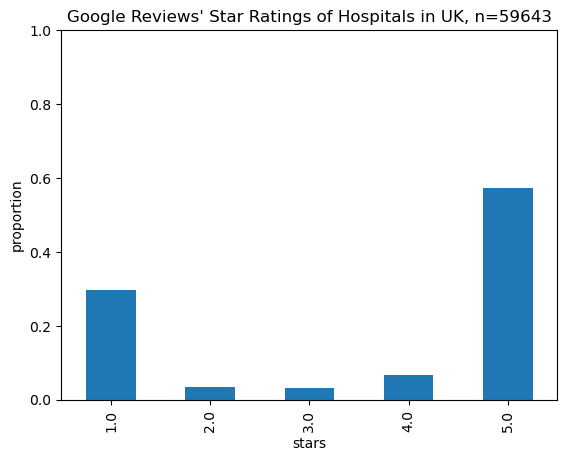

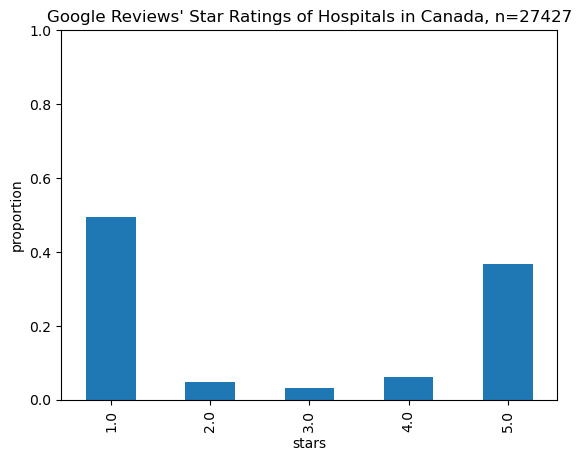

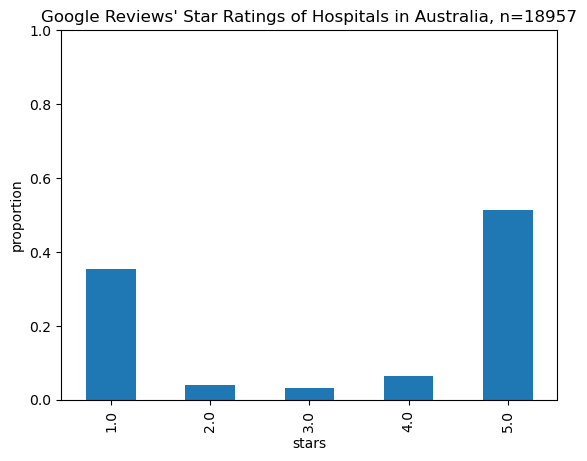

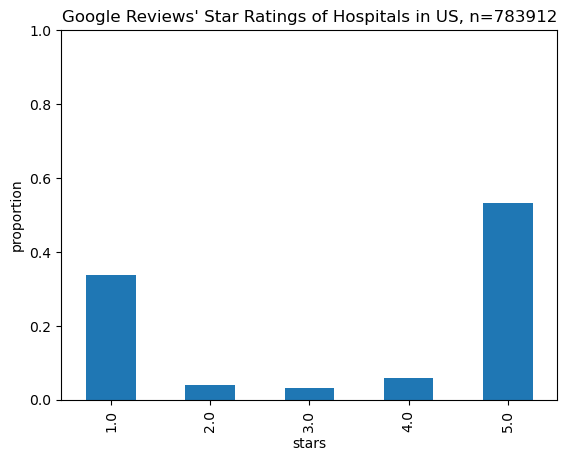

In [65]:
#Star distributions

for i in titles[1:]:
    df = combined_df[combined_df['country']==i]
    value_counts = df['stars'].value_counts(normalize=True).sort_index()
    value_counts.plot(kind='bar') 
    
    plt.ylabel("proportion")
    plt.ylim((0, 1))  
    plt.title(f"Google Reviews' Star Ratings of Hospitals in {i}, n={df.shape[0]}")
    plt.show()

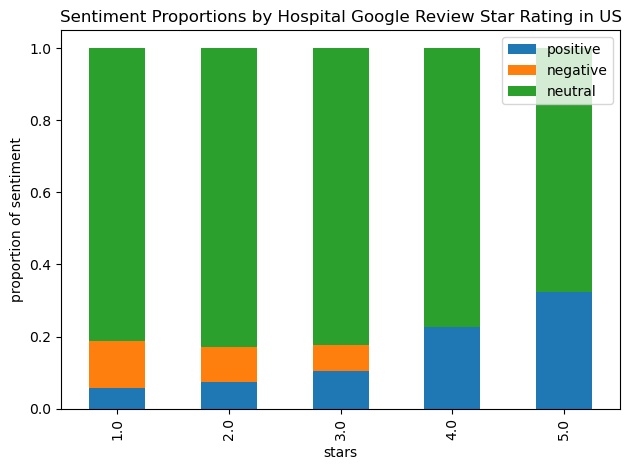

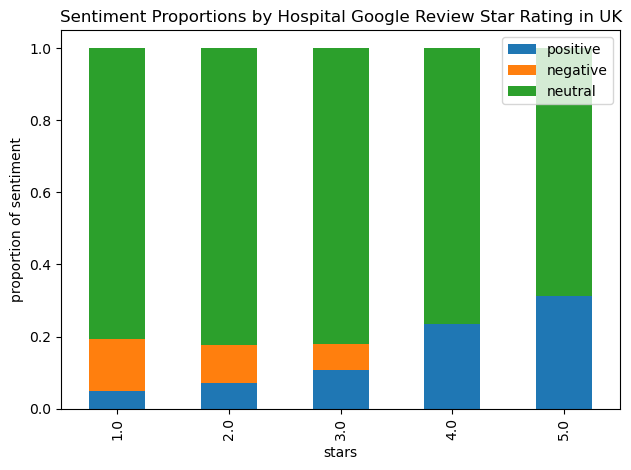

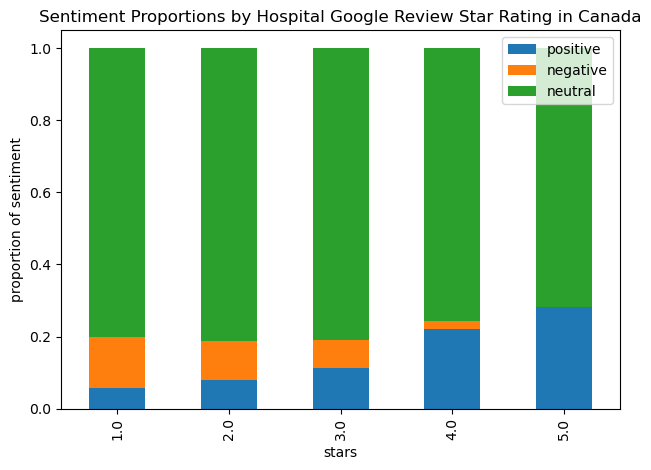

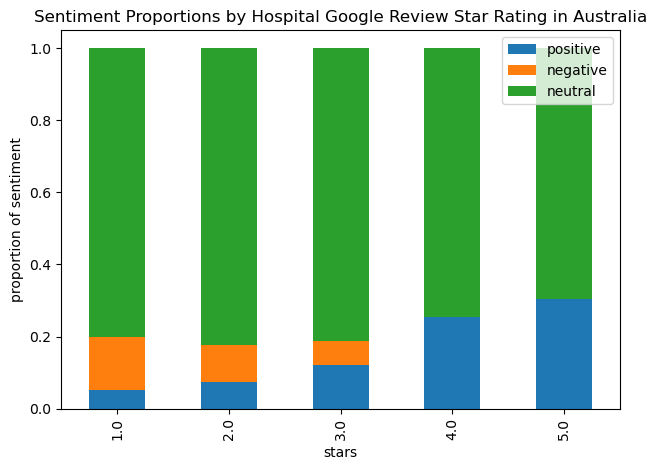

In [47]:
#Sentiment proportions by median

vader_df = combined_df[combined_df['translated'].isna()]
median_scores = vader_df.groupby(['country', 'stars'])[['positive', 'negative', 'neutral']].median().reset_index()

# Standardize the scores so they add up to 1
median_scores['total'] = median_scores['positive'] + median_scores['negative'] + median_scores['neutral']
median_scores['positive'] = median_scores['positive'] / median_scores['total']
median_scores['negative'] = median_scores['negative'] / median_scores['total']
median_scores['neutral'] = median_scores['neutral'] / median_scores['total']

# Drop the 'total' column as it's no longer needed
median_scores.drop('total', axis=1, inplace=True)

for country in titles[:4]:
    country_data = median_scores[median_scores['country'] == country]
    country_data.set_index('stars', inplace=True)
    
    country_data[['positive', 'negative', 'neutral']].plot(kind='bar', stacked=True)
    plt.ylabel('proportion of sentiment')
    plt.title(f'Sentiment Proportions by Hospital Google Review Star Rating in {country}')
    plt.tight_layout()
    plt.show()

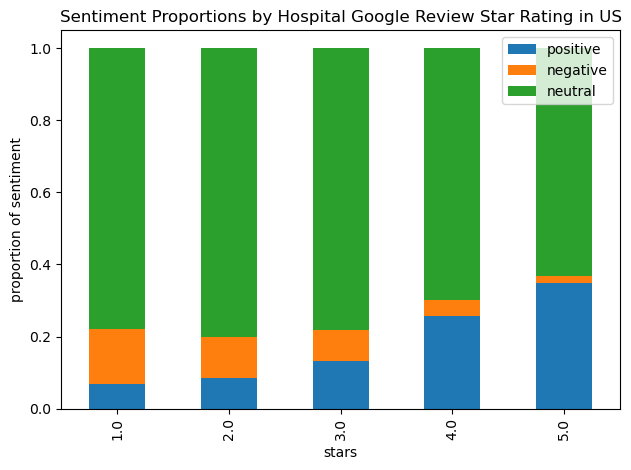

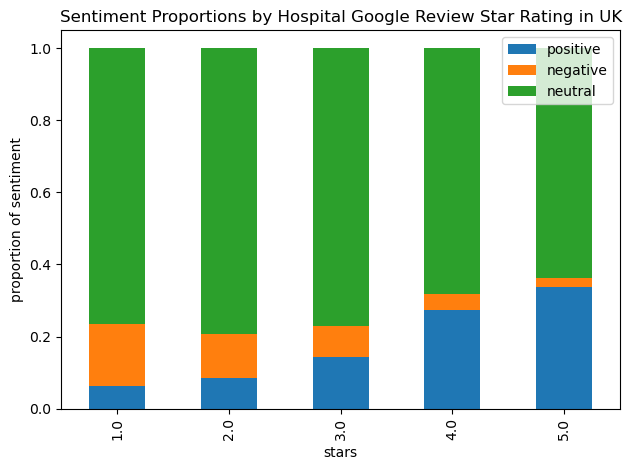

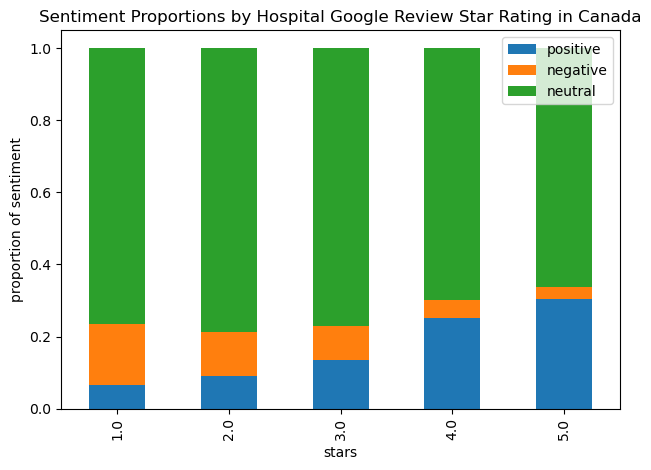

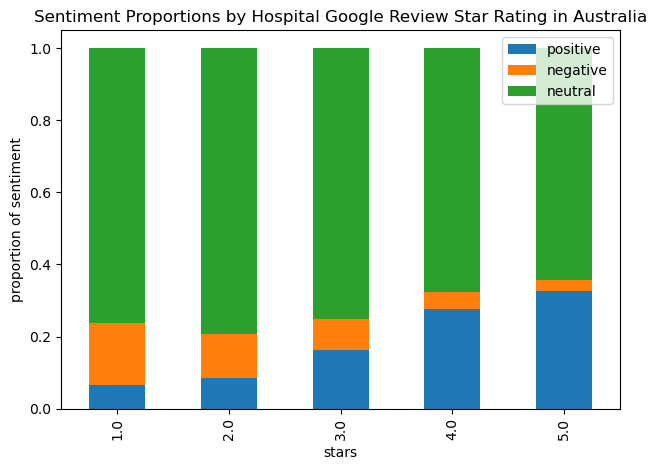

In [51]:
#Sentiment proportions by mean

mean_scores = vader_df.groupby(['country', 'stars'])[['positive', 'negative', 'neutral']].mean().reset_index()

# Standardize the scores so they add up to 1
mean_scores['total'] = mean_scores['positive'] + mean_scores['negative'] + mean_scores['neutral']
mean_scores['positive'] = mean_scores['positive'] / mean_scores['total']
mean_scores['negative'] = mean_scores['negative'] / mean_scores['total']
mean_scores['neutral'] = mean_scores['neutral'] / mean_scores['total']

# Drop the 'total' column as it's no longer needed
mean_scores.drop('total', axis=1, inplace=True)

for country in titles[:4]:
    country_data = mean_scores[mean_scores['country'] == country]
    country_data.set_index('stars', inplace=True)
    
    country_data[['positive', 'negative', 'neutral']].plot(kind='bar', stacked=True)
    plt.ylabel('proportion of sentiment')
    plt.title(f'Sentiment Proportions by Hospital Google Review Star Rating in {country}')
    plt.tight_layout()
    plt.show()

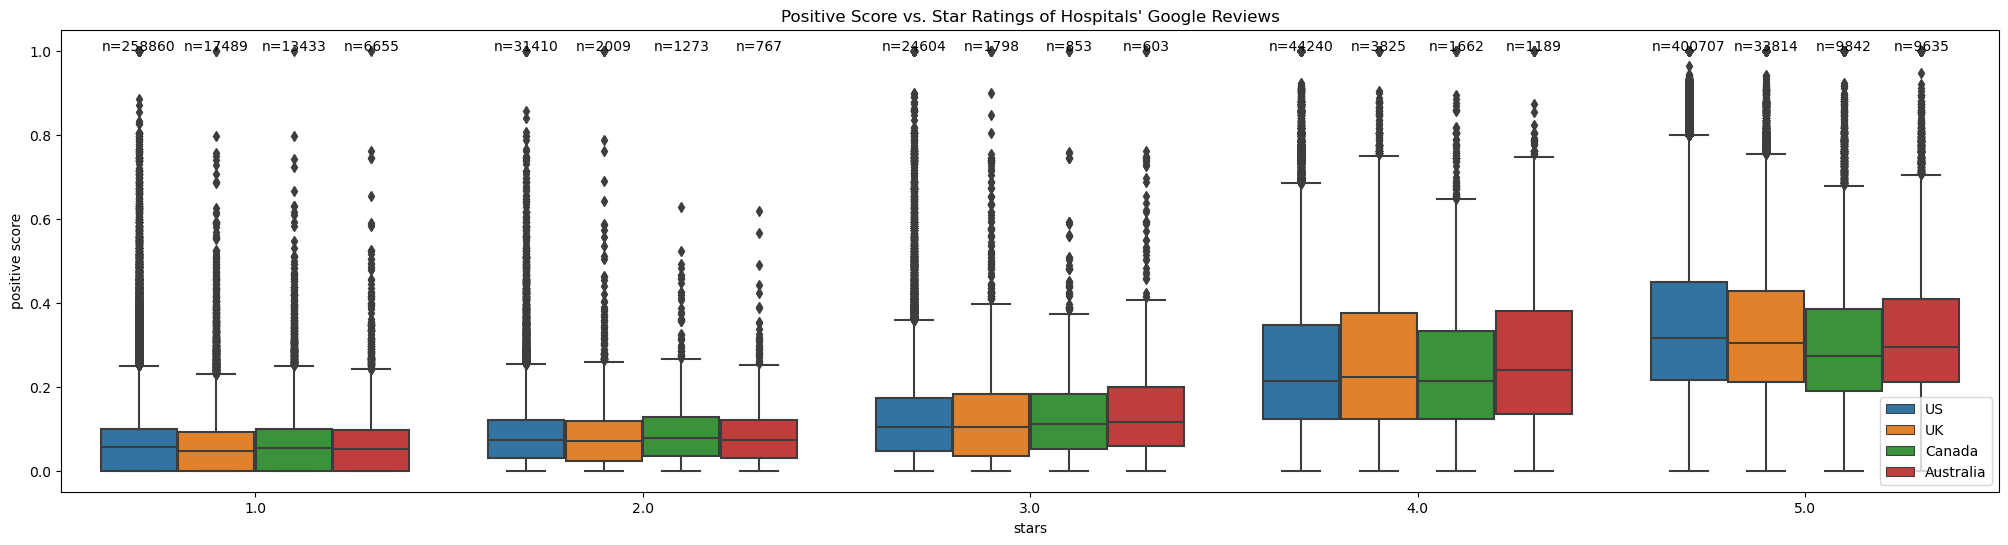

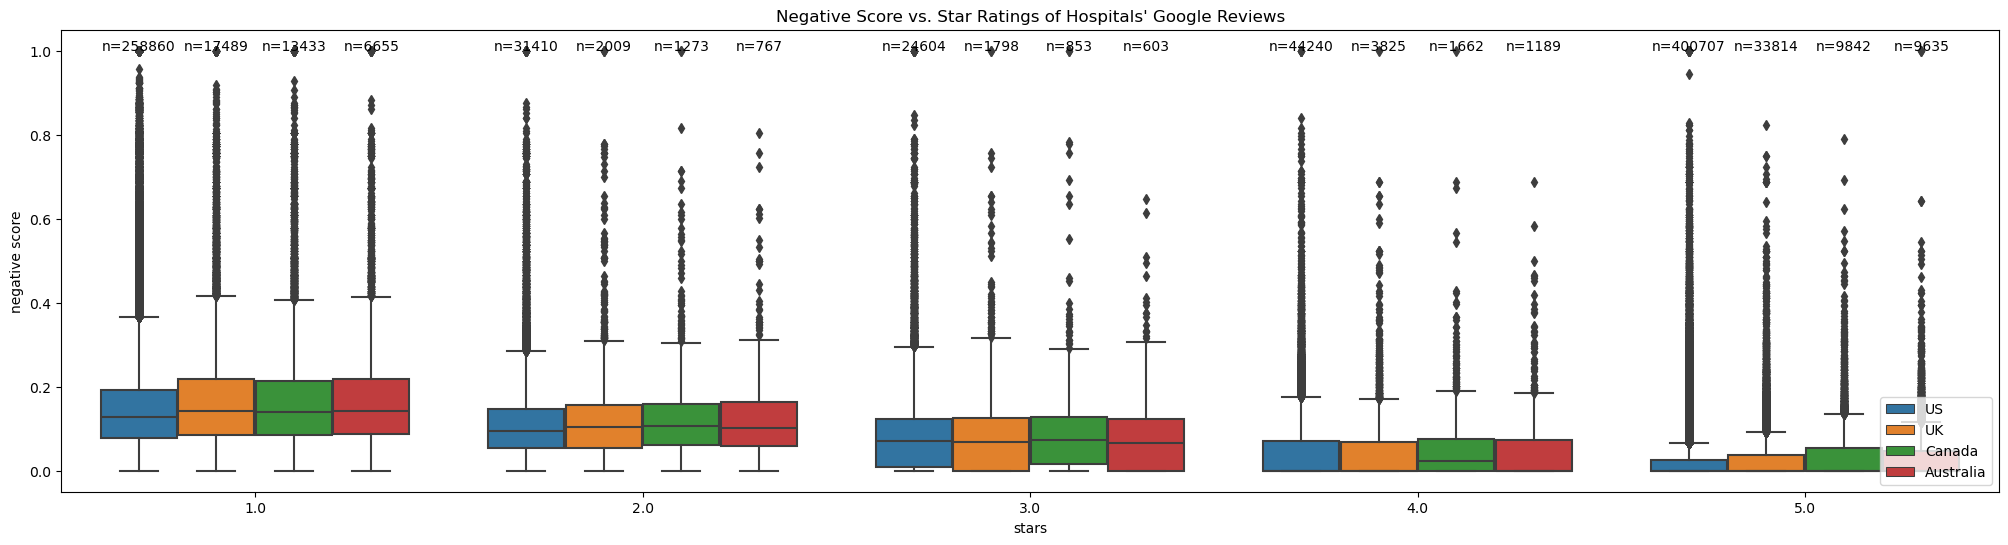

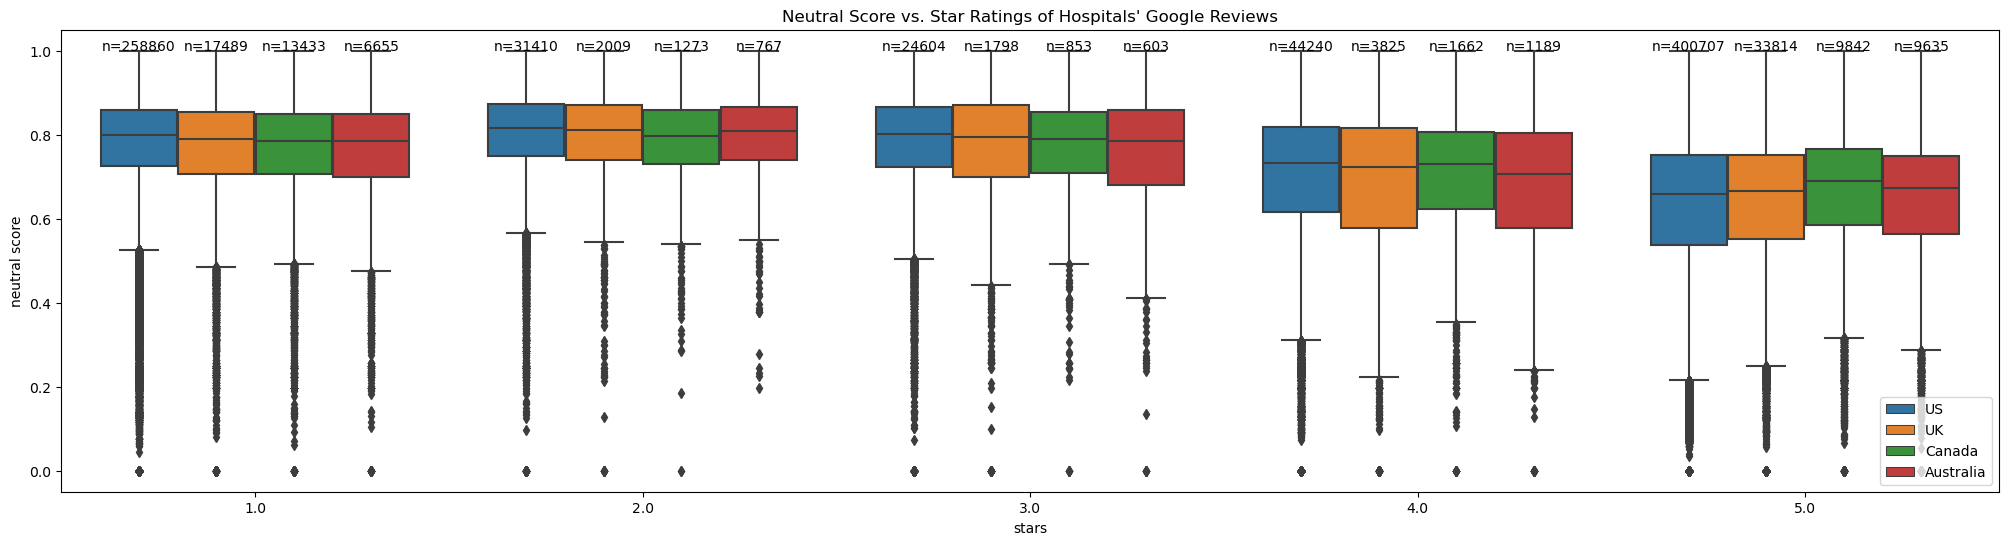

In [67]:
#Star vs sentiment

def n_label(sent): 
    plt.figure(figsize=(25,6))
    sns.boxplot(x='stars', y=sent, data=vader_df, hue='country')
    plt.title(f'{sent.capitalize()} Score vs. Star Ratings of Hospitals\' Google Reviews')
    plt.xlabel('stars')
    plt.ylabel(f'{sent} score')
    plt.legend(loc = 'lower right')

    sample_sizes = vader_df.groupby(['stars', 'country']).size().reset_index(name='count')
    medians = vader_df.groupby(['stars', 'country'])[sent].median().reset_index()
    merged = sample_sizes.merge(medians, on=['stars', 'country'])

    # Get unique stars and countries for positioning
    stars_unique = vader_df['stars'].unique()
    stars_unique = sorted(stars_unique)
    countries_unique = vader_df['country'].unique()

    # Add sample size labels
    for i, row in merged.iterrows():
        stars = row['stars']
        country = row['country']
        count = row['count']
        
        # Get the position of the boxplot
        x = list(stars_unique).index(stars)
        hue = list(countries_unique).index(country)
        
        # Adjust position for multiple hues
        box_width = 0.8 / len(countries_unique)  # Total width is 0.8, divided by number of hues
        x_offset = x - 0.4 + (hue + 0.5) * box_width  # Center the boxes
        
        # Add the text above the median line inside the boxplot
        plt.text(
            x_offset, 
            1,  
            f'n={count}',
            ha='center')  

    plt.show()

n_label('positive')
n_label('negative')
n_label('neutral')



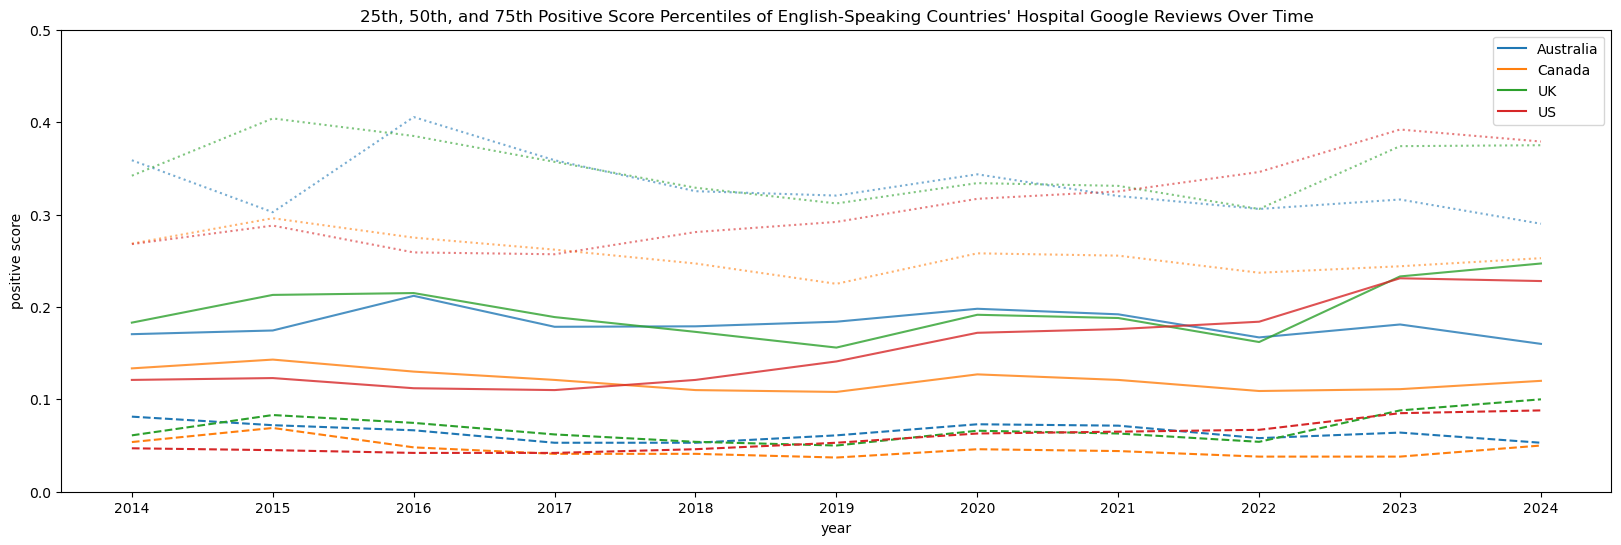

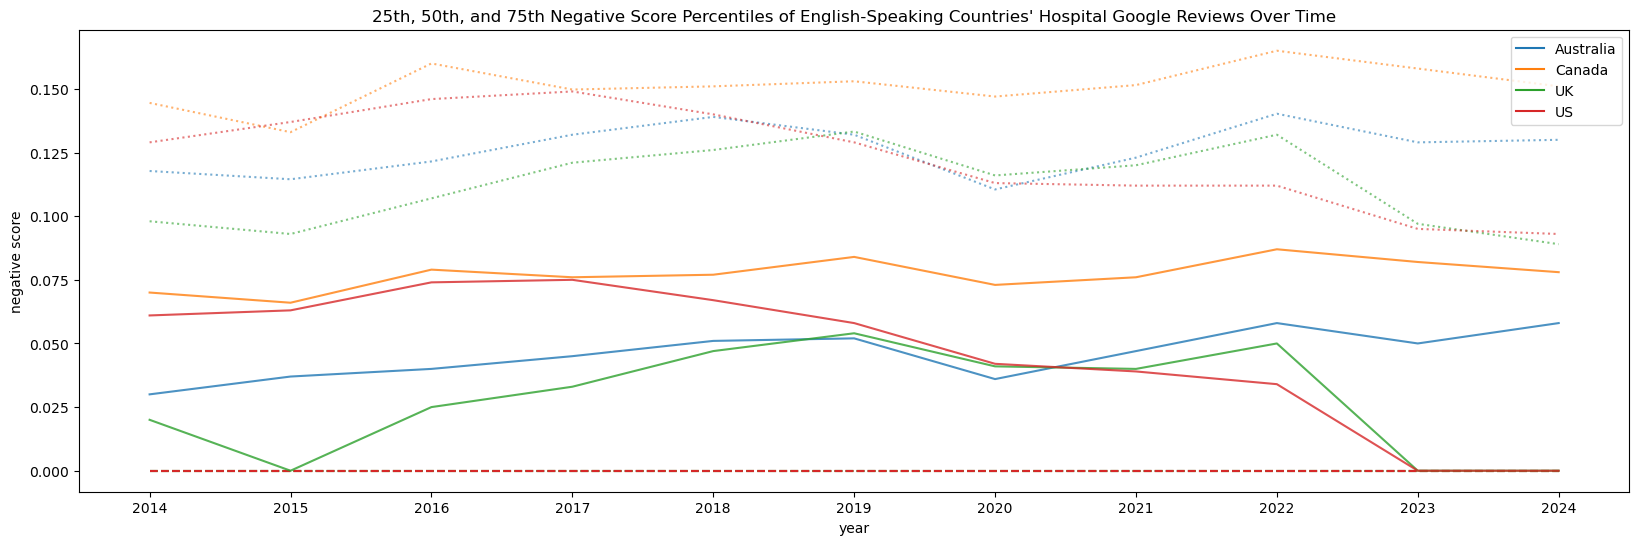

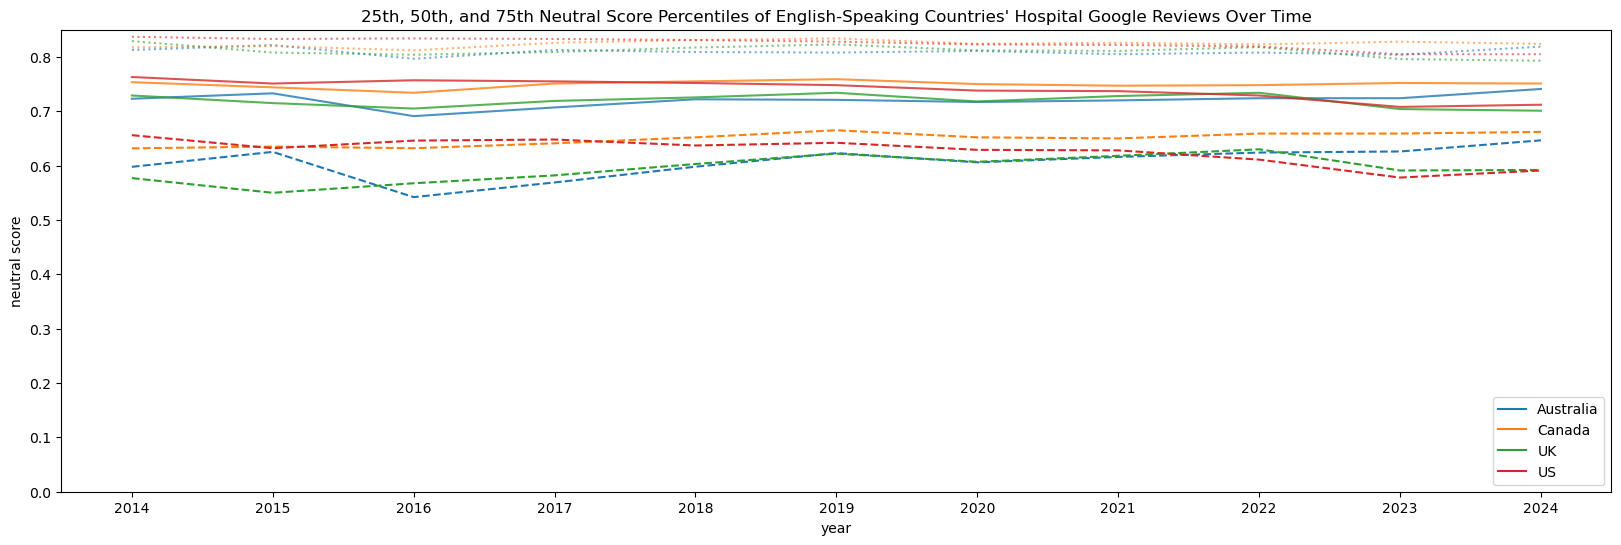

In [110]:
#Lineplots for sentiment over time

def calculate_quantiles(df, sentiment):
    quantiles = df.groupby(['year', 'country'])[sentiment].quantile([0.25, 0.5, 0.75]).unstack().reset_index()
    quantiles.columns = ['year', 'country', 'q1', 'median', 'q3']
    quantiles['year'] = quantiles['year'].astype(int) + 1970
    return quantiles

positive_quantiles = calculate_quantiles(vader_df, 'positive')
negative_quantiles = calculate_quantiles(vader_df, 'negative')
neutral_quantiles = calculate_quantiles(vader_df, 'neutral')

# plt.figure(figsize=(20,6))
# sns.lineplot(x='year', y='q1', data=positive_quantiles, hue='country', legend=True, linestyle='--')
# sns.lineplot(x='year', y='median', data=positive_quantiles, hue='country', legend=False, alpha=0.8)
# sns.lineplot(x='year', y='q3', data=positive_quantiles, hue='country', legend=False, linestyle=':', alpha=0.6)
# plt.ylabel('positive score')
# plt.title('25th, 50th, and 75th Positive Score Percentiles of English-Speaking Countries\' Hospital Google Reviews Over Time')
# plt.legend(loc='upper right')
# plt.ylim((0,.5))
# plt.xticks(ticks=positive_quantiles['year'].unique())
# plt.show()


In [6]:
#Compile stopwords

stop = set()
for i in stopwords.fileids():
    stop.update(stopwords.words(i))
stop_list = list(stop)

print(len(stopwords.fileids()))


29


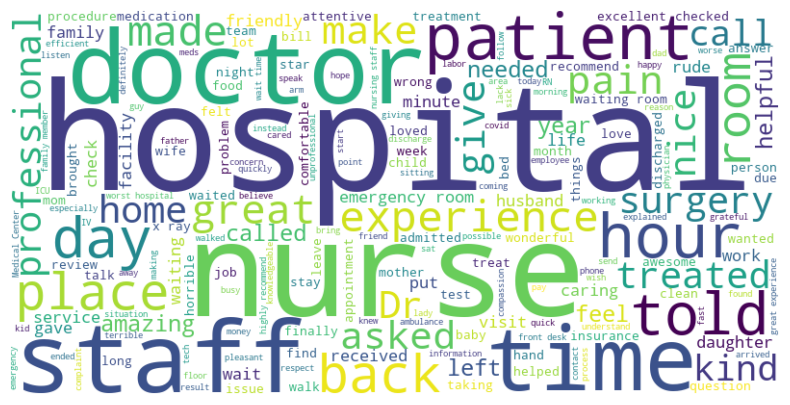

In [93]:
#Wordcloud

us_wc = combined_df[(combined_df['country']=='US')]
wordcloud = WordCloud(width=800, height=400, background_color='white',stopwords=stop_list).generate(us_wc['text'].str.cat(sep=' '))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.show()

In [12]:
#Topic model trying to optimize number of topics

# Define the range for the number of topics
num_topics_range = [100,200,300,400]

# Store coherence scores
coherence_scores = []

for num_topics in num_topics_range:
    # Initialize BERTopic with a specific number of topics
    topic_model = BERTopic(language="multilingual",n_gram_range=(1,3),nr_topics=num_topics)
    topics, probs = topic_model.fit_transform(uk_sent['text'])

    documents = pd.DataFrame({"Document": uk_sent['text'],
                            "ID": range(len(uk_sent['text'])),
                            "Topic": topics})
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

    # Extract vectorizer and analyzer from BERTopic
    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # Extract features for Topic Coherence evaluation
    words = vectorizer.get_feature_names_out()
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
                for topic in range(len(set(topics))-1)]
    
    # Compute coherence score
    coherence_model = CoherenceModel(
        topics=topic_words, 
        texts=tokens,
        corpus=corpus,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    print(f"Number of Topics: {num_topics}, Coherence Score: {coherence_score}")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
TOKENIZERS_PARALLELISM=(true | false)
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of Topics: 100, Coherence Score: 0.4646649143931688


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable 	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of Topics: 200, Coherence Score: 0.40189183264594286


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of Topics: 300, Coherence Score: 0.3564803249859761


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of Topics: 400, Coherence Score: 0.37085875273716046


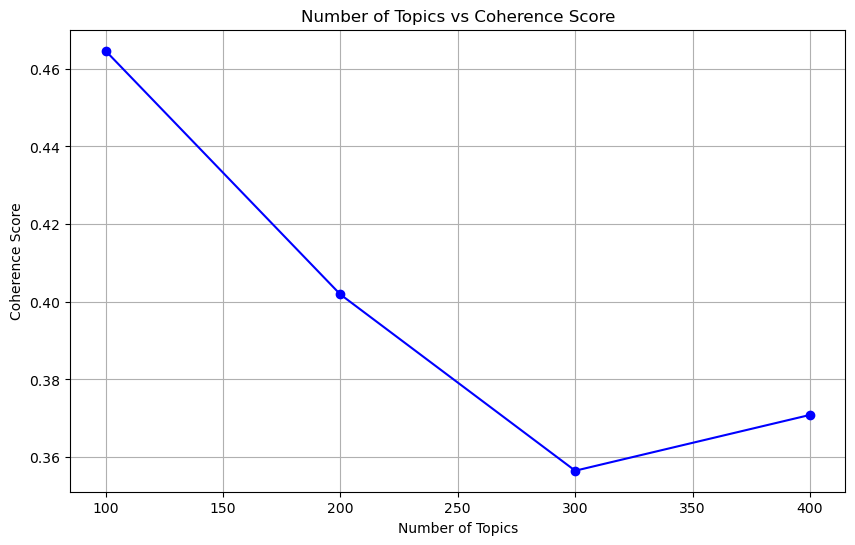

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(num_topics_range, coherence_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Number of Topics vs Coherence Score')
plt.show()

In [7]:
#Tokenizer

class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        tokens = [t.lower() for t in tokens if any(char.isalpha() for char in t) and len(t) > 1]
        tagged_tokens = pos_tag(tokens)
        lemmatized_tokens = [self.wnl.lemmatize(word, self.get_wordnet_pos(tag)) for word, tag in tagged_tokens]
        return lemmatized_tokens
    
    def get_wordnet_pos(self, treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
    
tokenizer = LemmaTokenizer()
doc = "Hello world! This is doing a test with 123, special characters: @#* and symbols like ~. Also, single letters like a or I, and hyphenated words like good-bye."
print(tokenizer(doc))

['hello', 'world', 'this', 'be', 'do', 'test', 'with', 'special', 'character', 'and', 'symbol', 'like', 'also', 'single', 'letter', 'like', 'or', 'and', 'hyphenated', 'word', 'like', 'good-bye']


In [8]:
#Save topics for each country for each year

result_matrices = {}
years = [year for year in range(2014, 2025)]

for i in titles[1:]:   
    print(f'{i}') 
    df = combined_df[combined_df['country']==i]
    vectorizer_model = CountVectorizer(tokenizer=LemmaTokenizer(), stop_words=stop_list, ngram_range=(1, 4))
    topic_model = BERTopic(language="multilingual",vectorizer_model=vectorizer_model)
    
    topic_info = {}
    for j in years:
        print(f'{j}')
        df_filtered = df[df['year'] == pd.Period(f'{j}', freq='Y')]
        print(df_filtered['year'].value_counts())
        if not df_filtered['text'].empty:
            topics, probs = topic_model.fit_transform(df_filtered['text'])
            topic_info[j] = topic_model.get_topic_info()
        else:
            topic_info[j] = []
    result_matrices[i] = topic_info

with open('result_matrice_full.pkl', 'wb') as file:
    pickle.dump(result_matrices, file)

UK
2014
year
2014    503
Freq: Y-DEC, Name: count, dtype: int64
2015
year
2015    975
Freq: Y-DEC, Name: count, dtype: int64
2016
year
2016    2238
Freq: Y-DEC, Name: count, dtype: int64
2017
year
2017    3474
Freq: Y-DEC, Name: count, dtype: int64
2018
year
2018    4206
Freq: Y-DEC, Name: count, dtype: int64
2019
year
2019    5064
Freq: Y-DEC, Name: count, dtype: int64
2020
year
2020    3482
Freq: Y-DEC, Name: count, dtype: int64
2021
year
2021    6627
Freq: Y-DEC, Name: count, dtype: int64
2022
year
2022    9510
Freq: Y-DEC, Name: count, dtype: int64
2023
year
2023    14331
Freq: Y-DEC, Name: count, dtype: int64
2024
year
2024    9233
Freq: Y-DEC, Name: count, dtype: int64
Canada
2014
year
2014    149
Freq: Y-DEC, Name: count, dtype: int64
2015
year
2015    341
Freq: Y-DEC, Name: count, dtype: int64
2016
year
2016    1117
Freq: Y-DEC, Name: count, dtype: int64
2017
year
2017    1932
Freq: Y-DEC, Name: count, dtype: int64
2018
year
2018    2519
Freq: Y-DEC, Name: count, dtype: int64
2

python(3962) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
python(3963) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
python(3964) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, 

2017
year
2017    36911
Freq: Y-DEC, Name: count, dtype: int64


python(4111) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
python(4112) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
python(4113) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, 

2018
year
2018    48068
Freq: Y-DEC, Name: count, dtype: int64


python(4280) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
python(4281) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
python(4282) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, 

2019
year
2019    62634
Freq: Y-DEC, Name: count, dtype: int64


python(4523) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
python(4524) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
python(4525) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, 

2020
year
2020    53979
Freq: Y-DEC, Name: count, dtype: int64


python(4677) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
python(4678) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
python(4679) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, 

2021
year
2021    103372
Freq: Y-DEC, Name: count, dtype: int64


python(4940) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
python(4941) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
python(4942) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, 

2022
year
2022    141045
Freq: Y-DEC, Name: count, dtype: int64


python(5595) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
python(5596) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
python(5597) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, 

2023
year
2023    185673
Freq: Y-DEC, Name: count, dtype: int64


python(5934) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
python(5935) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
python(5936) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, 

2024
year
2024    109312
Freq: Y-DEC, Name: count, dtype: int64


python(6241) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
python(6242) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
python(6243) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, 

In [4]:
#Create country dfs for topics over time

years = [year for year in range(2014, 2025)]

with open('results/result_matrices_full.pkl', 'rb') as file:
    result = pickle.load(file)

def country_topic_time(country_data):
    df_list = []
    for year in years:
        df = country_data[year][['Count', 'Name']].copy()
        df['year'] = year
        df_list.append(df)
    return pd.concat(df_list, ignore_index=True)

uk_time = country_topic_time(result['UK'])
us_time = country_topic_time(result['US'])
aus_time = country_topic_time(result['Australia'])
cn_time = country_topic_time(result['Canada'])

for df in [uk_time, us_time, aus_time, cn_time]:
    df['year'] = df['year'].astype(int) 

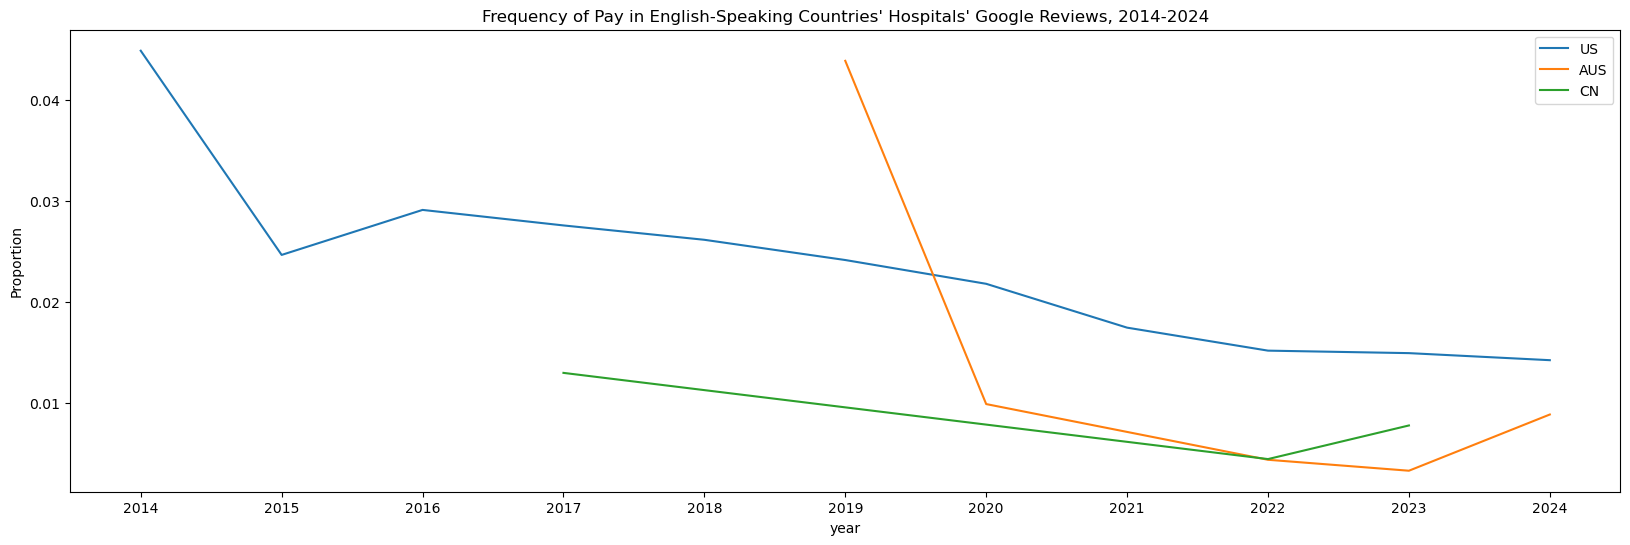

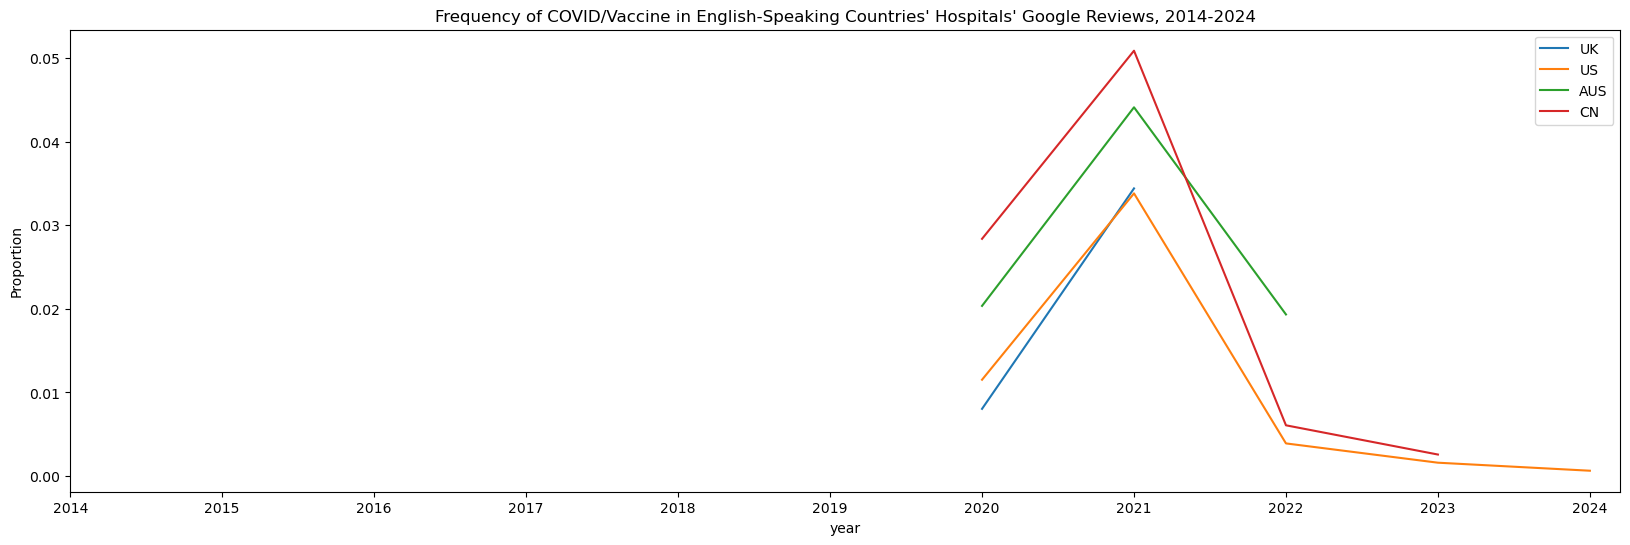

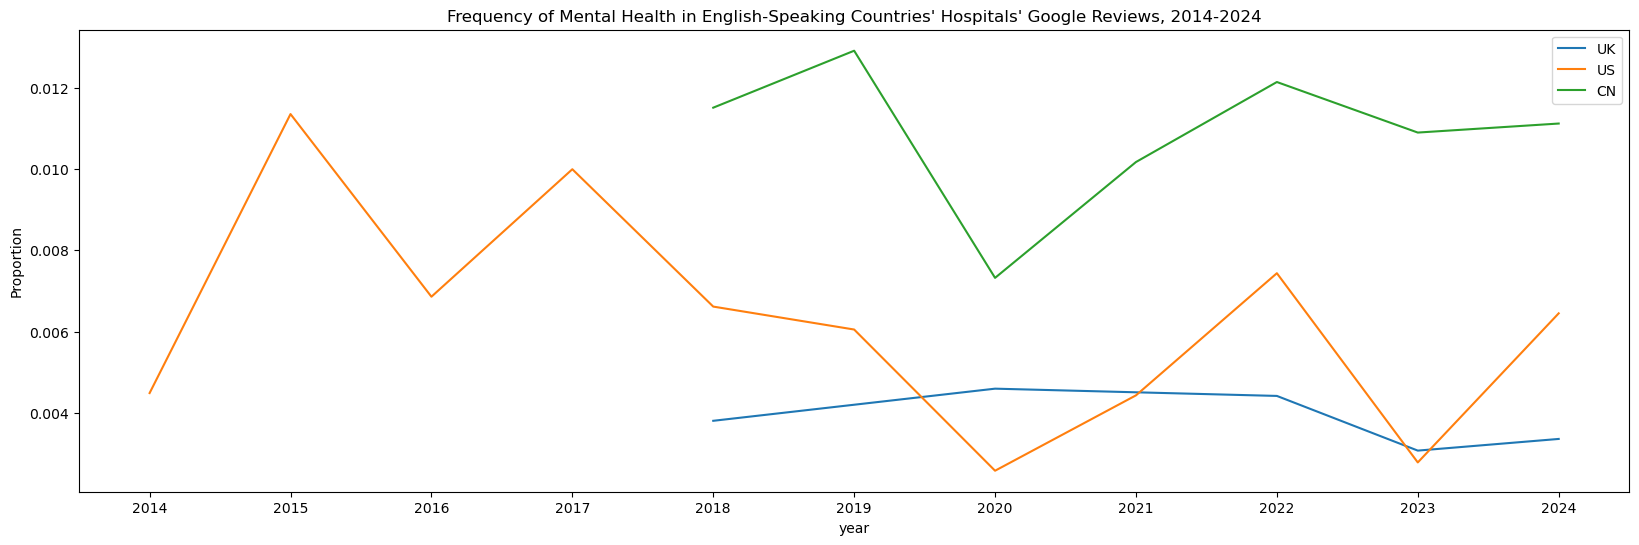

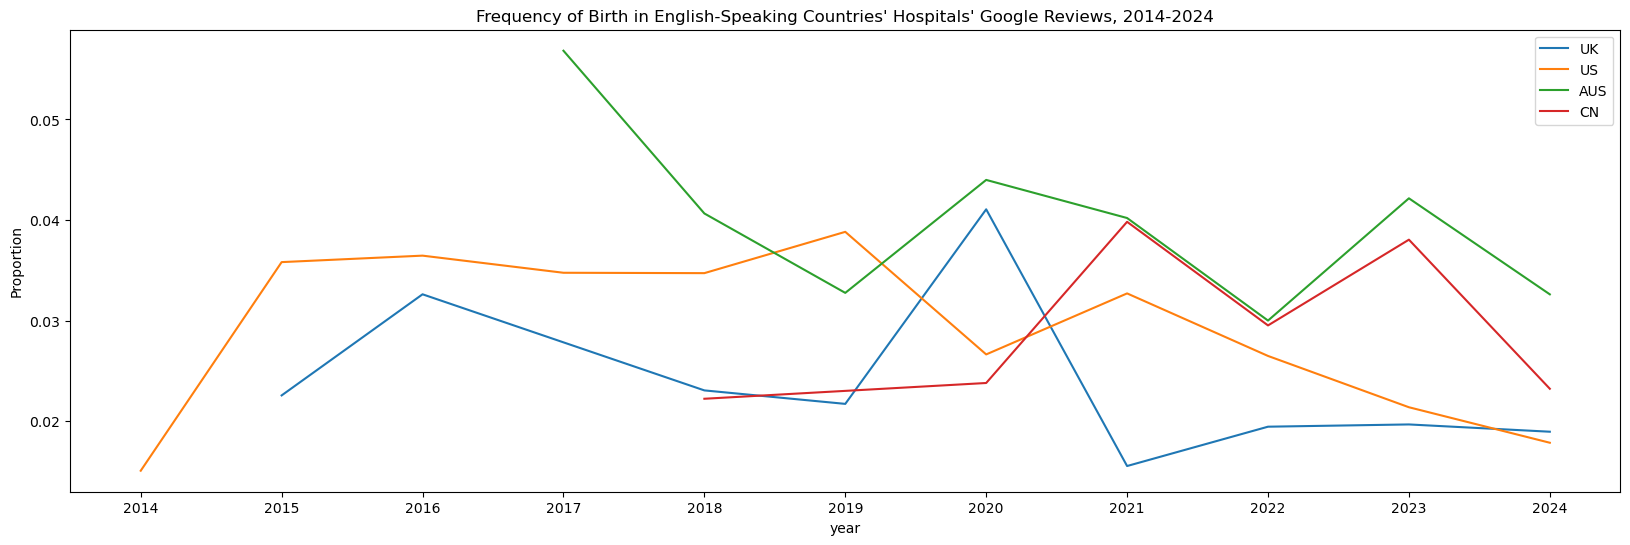

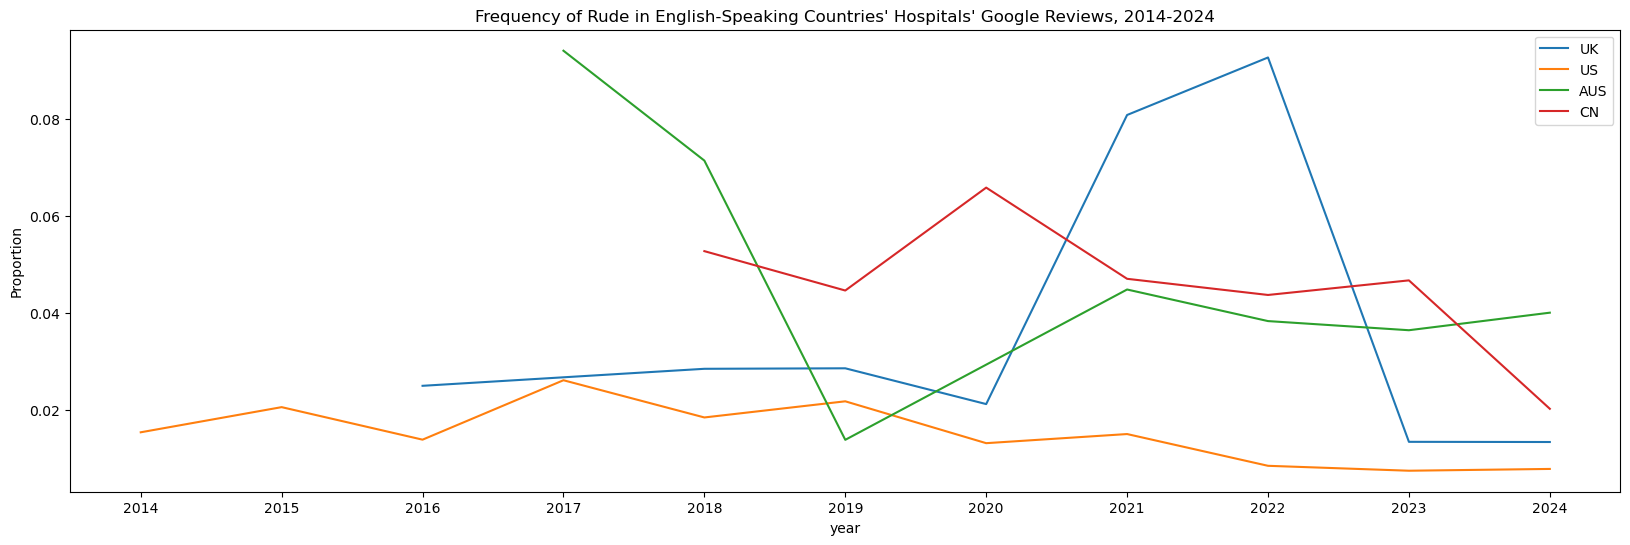

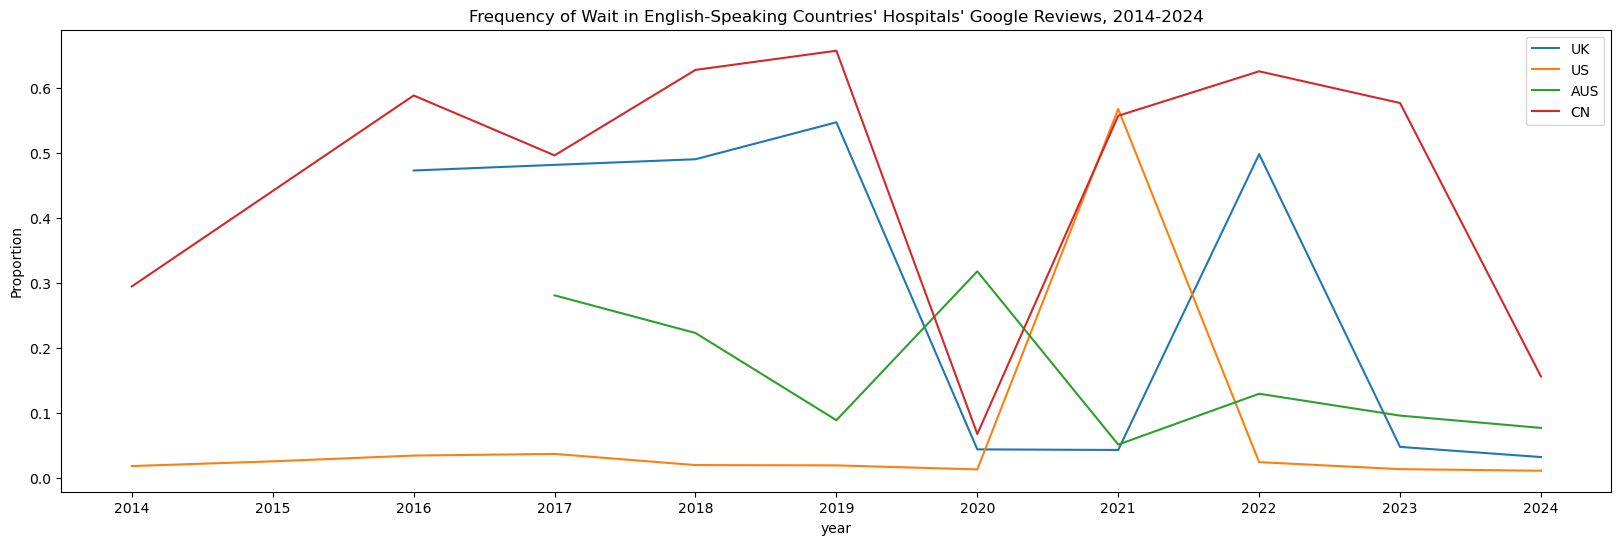

In [7]:
#Topic time series

topic_titles = ['Pay', 'COVID/Vaccine', 'Mental Health', 'Birth', 'Rude', 'Wait']
search_patterns = ['bill|insurance|pay|charge', 'vaccin|covid', 'mental', 'birth', 'rude', 'wait']

# Define the function to filter and group the data
def filter_and_group(data, pattern):
    filtered = data[data['Name'].str.contains(pattern, case=False, na=False)]
    grouped = filtered.groupby('year', as_index=False)['Count'].sum()
    total_counts = data.groupby('year', as_index=False)['Count'].sum().rename(columns={'Count': 'Total_Count'})
    
    merged = grouped.merge(total_counts, on='year')
    merged['Proportion'] = merged['Count'] / merged['Total_Count']
    
    return merged[['year', 'Proportion']]
   
# Iterate through topics and regions
for title, pattern in zip(topic_titles, search_patterns):
    plt.figure(figsize=(20, 6))

    for region_name, region_data in zip(['UK', 'US', 'AUS', 'CN'], [uk_time, us_time, aus_time, cn_time]):
        filtered_data = filter_and_group(region_data, pattern)
        if len(filtered_data) >= 2:
            sns.lineplot(x='year', y='Proportion', data=filtered_data, label=region_name)
                
    plt.ylabel('Proportion')
    plt.title(f'Frequency of {title} in English-Speaking Countries\' Hospitals\' Google Reviews, 2014-2024')
    plt.xticks(ticks=uk_time['year'].unique())
    plt.legend()
    plt.show()

In [21]:
#Topics of Worst and Best Reviews, 2019 vs. 2020

np.random.seed(42)
random.seed(42)

custom_labels = {
    0: "Topic 1",
    1: "Topic 2",
    2: "Topic 3",
    3: 'Topic 4'
}

for i in [2019,2020]:
    for j in [1,5]:
        df = combined_df[(combined_df['year'] == pd.Period(i, freq='Y')) & (combined_df['stars'] == j)]
        print(df.shape)

        vectorizer_model = CountVectorizer(tokenizer=LemmaTokenizer(), stop_words=stop_list, ngram_range=(1, 4))
        topic_model = BERTopic(language="multilingual",vectorizer_model=vectorizer_model)
        topics, probs = topic_model.fit_transform(df['text'])

        topic_model.set_topic_labels(custom_labels)
        fig = topic_model.visualize_barchart(top_n_topics=4, title=f'Top Topics of English-Speaking Countries\' Hospitals\' {j}-Star Google Reviews, {i}', custom_labels=True)
        pio.show(fig)  


(30253, 9)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

(31978, 9)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

(21197, 9)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

(31347, 9)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
